# Thyroid Analysis

In [1]:
!pip install pynrrd

In [1]:
import cv2
import numpy as np
import nrrd
import glob
import matplotlib.pyplot as plt
import tensorflow as tf
import os

## 1. NRRD Files

In [2]:
# Set the directory you want to list files from
directory = 'dataUSGthyroid/SAMSUNG'

# Use the glob module to create a list of file paths
images_paths = sorted(glob.glob(directory + '/images' + '**/*', recursive=True))
contoures_paths = sorted(glob.glob(directory + '/masks' + '**/*', recursive=True))

In [3]:
images_paths[:10]

['dataUSGthyroid/SAMSUNG/images/109800_image.nrrd',
 'dataUSGthyroid/SAMSUNG/images/1104018_image.nrrd',
 'dataUSGthyroid/SAMSUNG/images/1109437_image.nrrd',
 'dataUSGthyroid/SAMSUNG/images/11276_image.nrrd',
 'dataUSGthyroid/SAMSUNG/images/1127758_image.nrrd',
 'dataUSGthyroid/SAMSUNG/images/1129218_image.nrrd',
 'dataUSGthyroid/SAMSUNG/images/1155158_image.nrrd',
 'dataUSGthyroid/SAMSUNG/images/1186918_image.nrrd',
 'dataUSGthyroid/SAMSUNG/images/1212278_image.nrrd',
 'dataUSGthyroid/SAMSUNG/images/121857_image.nrrd']

In [4]:
contoures_paths[:10]

['dataUSGthyroid/SAMSUNG/masks/109800_label.nrrd',
 'dataUSGthyroid/SAMSUNG/masks/1104018_label.nrrd',
 'dataUSGthyroid/SAMSUNG/masks/1109437_label.nrrd',
 'dataUSGthyroid/SAMSUNG/masks/11276_label.nrrd',
 'dataUSGthyroid/SAMSUNG/masks/1127758_label.nrrd',
 'dataUSGthyroid/SAMSUNG/masks/1129218_label.nrrd',
 'dataUSGthyroid/SAMSUNG/masks/1155158_label.nrrd',
 'dataUSGthyroid/SAMSUNG/masks/1186918_label.nrrd',
 'dataUSGthyroid/SAMSUNG/masks/1212278_label.nrrd',
 'dataUSGthyroid/SAMSUNG/masks/121857_label.nrrd']

In [142]:
# Read the NRRD file
nrrd_data, header = nrrd.read(images_paths[220])

# Print the NRRD header
print(header)

# Access the data from the NRRD file
# print(nrrd_data)

OrderedDict([('type', 'uint8'), ('dimension', 3), ('sizes', array([614, 816,   3])), ('encoding', 'gzip')])


In [143]:
nrrd_data.shape

(614, 816, 3)

In [144]:
header

OrderedDict([('type', 'uint8'),
             ('dimension', 3),
             ('sizes', array([614, 816,   3])),
             ('encoding', 'gzip')])

In [145]:
len(contoures_paths)

606

In [ ]:
X_MARGIN = 1
Y_MARGIN = 30

i = 120

print(images_paths[i])
print(contoures_paths[i])

# Read images
image1, header = nrrd.read(images_paths[i])
image2, header = nrrd.read(contoures_paths[i])

# image1 = image1[X_MARGIN:-X_MARGIN, Y_MARGIN:-Y_MARGIN]
# image2 = image2[X_MARGIN:-X_MARGIN, Y_MARGIN:-Y_MARGIN]

fig = plt.figure(figsize=(15, 15))

# Create a single subplot
ax = plt.subplot()

ax.imshow(image1)

min_x, max_x = 190, 1080
min_y, max_y = 125, 760

ax.plot([min_x, min_x], [min_y, max_y], color='red', linewidth=2)
ax.plot([max_x, max_x], [min_y, max_y], color='red', linewidth=2)

ax.plot([min_x, max_x], [min_y, min_y], color='red', linewidth=2)
ax.plot([min_x, max_x], [max_y, max_y], color='red', linewidth=2)
ax.imshow(image2, alpha=0.1)

# Show the figure
plt.show()

In [29]:
def cut_image_and_mask(image, mask, min_x, max_x, min_y, max_y):
    cut_image = image[min_y:max_y, min_x:max_x] 
    cut_mask = mask[min_y:max_y, min_x:max_x] 
    return cut_image, cut_mask

def get_new_path(old_path, new_dir='samsung_processed'):
    path = old_path.split('/')
    path[1] = new_dir
    path = '/'.join(path)
    return path

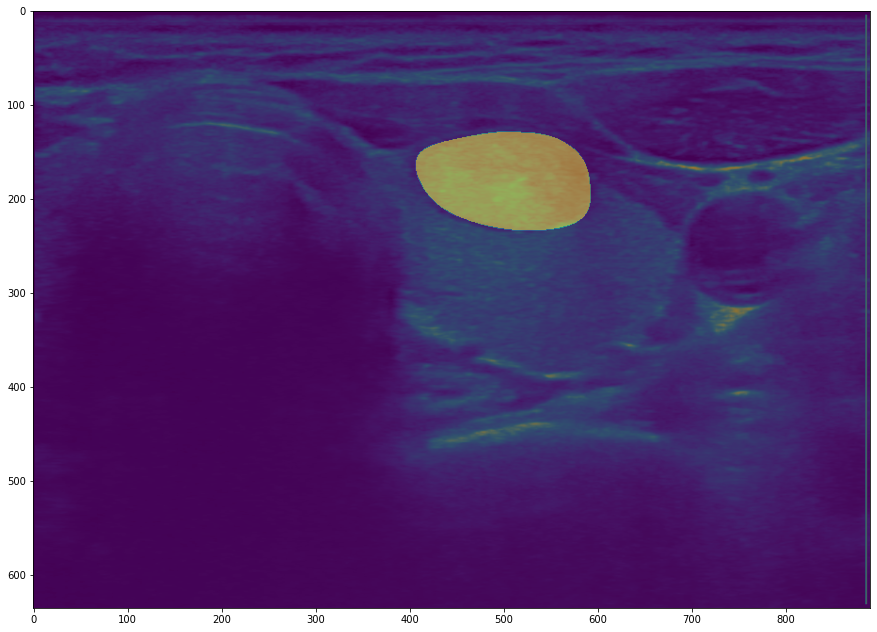

In [27]:
cut_image, cut_mask = cut_image_and_mask(image1, image2, 190, 1080, 125, 760)

fig = plt.figure(figsize=(15, 15))

# Create a single subplot
ax = plt.subplot()
ax.imshow(cut_image)
ax.imshow(cut_mask, alpha=0.5)
plt.show()

In [31]:
for image_path, mask_path in zip(images_paths, contoures_paths):
    image, header = nrrd.read(image_path)
    mask, header = nrrd.read(mask_path)
    
    cut_image, cut_mask = cut_image_and_mask(image, mask, 190, 1080, 125, 760)
    new_image_path = get_new_path(image_path)
    new_mask_path = get_new_path(mask_path)
    
    cut_image = np.expand_dims(cut_image, 2)
    cut_mask = np.expand_dims(cut_mask, 2)
    
    nrrd.write(new_image_path, cut_image)
    nrrd.write(new_mask_path, cut_mask)

In [18]:
header

OrderedDict([('type', 'uint8'),
             ('dimension', 2),
             ('sizes', array([360, 560])),
             ('encoding', 'gzip')])

In [19]:
image.shape

(360, 560)

In [20]:
cropped_image = image[min_y:max_y, min_x:max_x]

In [21]:
cropped_image.shape

(304, 487)

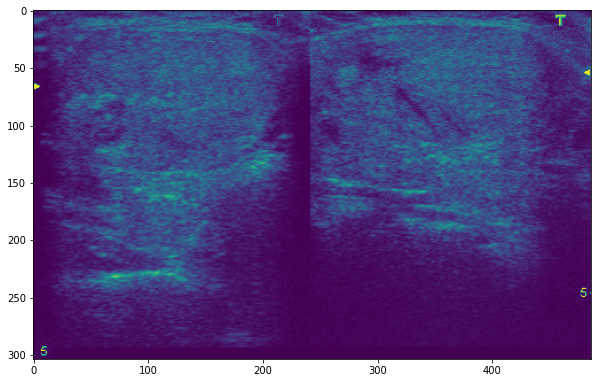

In [22]:
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot()
ax.imshow(cropped_image)
plt.show()

### Process Images

In [23]:
len(images_paths)

480

In [24]:
def extract_raw_images(images_paths, contoures_paths, save=True, resize='padding'):
    points = []
    full_images = []
    images = []
    masks = []
    failed = []
    
    for i in range(len(images_paths)):

        image, header = nrrd.read(images_paths[i])
        contour, header = nrrd.read(contoures_paths[i])

        try:
            min_x, max_x, min_y, max_y = detect_image_frame(image)
        except:
            failed.append(i)
            continue

        num = (max_x-min_x)
        den = (max_y-min_y)

        if den == 0:
            failed.append(i)
            continue

        ratio = num / den 

        if ratio > 3 or ratio < 0.33:
            failed.append(i)
            continue

        try:
            cropped_image = image[min_y:max_y, min_x:max_x]
            cropped_contour = contour[min_y:max_y, min_x:max_x]

            cropped_image = cropped_image[..., np.newaxis]
            cut_image = tf.image.resize(cropped_image, (512, 512))
            padded_image = tf.image.resize_with_pad(cropped_image, 512, 512)

            cropped_contour = cropped_contour[..., np.newaxis]
            cut_contour = tf.image.resize(cropped_contour, (512, 512))
            padded_contour = tf.image.resize_with_pad(cropped_contour, 512, 512)

            images.append(cropped_image)
            masks.append(cropped_contour)
            full_images.append(image)
            points.append([min_x, max_x, min_y, max_y])
        except:
            continue
            
    
    images = np.array(images)
    masks = np.array(masks)
    full_images = np.array(full_images)
    points = np.array(points)
    
    return images, masks, full_images, points
        

In [25]:
images, masks, full_images, points = extract_raw_images(images_paths,contoures_paths)

/home/sciemala/thyroid_analysis/.env/lib64/python3.6/site-packages/ipykernel_launcher.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/sciemala/thyroid_analysis/.env/lib64/python3.6/site-packages/ipykernel_launcher.py:53: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [26]:
print(images.shape)
print(masks.shape)
print(full_images.shape)
print(points.shape)

(480,)
(480,)
(480, 360, 560)
(480, 4)


In [45]:
images, masks = [], []

# Set the directory path
raw_dir = "dataUSGthyroid/samsung_processed"
raw_images = raw_dir + "/images"
raw_masks = raw_dir + "/masks"

i = 0
for image_path, mask_path in zip(images_paths, contoures_paths):
    image, header = nrrd.read(image_path)
    mask, header = nrrd.read(mask_path)
    
    image = np.expand_dims(np.array(image[130:-110, 290:-294]), 2)
    mask = np.expand_dims(np.array(mask[130:-110, 290:-294]), 2)
    
    nrrd.write(f'{raw_images}/{i}.nrrd', image)
    nrrd.write(f'{raw_masks}/{i}.nrrd', mask)
    i+=1

In [34]:
image.shape

(632, 696)

In [ ]:
image = images[0]
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot()
ax.imshow(image)
plt.show()

In [4]:
import matplotlib.pyplot as plt
import ipywidgets as widgets
import numpy as np
from math import ceil

COLS, ROWS = 4, 9
N_SUB = COLS * ROWS
N_TABS = ceil(len(images) / N_SUB)

In [28]:
%matplotlib inline

# N_TABS = 2

outs = [widgets.Output() for i in range(N_TABS)]
tab = widgets.Tab(children = outs)
for i in range(len(outs)): tab.set_title(i, str(i))
display(tab)

nth_image = 0
for n_tab, out in enumerate(outs):
    with out:
        fig, axs = plt.subplots(ROWS, COLS, figsize=(25, 25))
        sub_images = full_images[n_tab*N_SUB:(n_tab+1)*N_SUB]
        sub_points = points[n_tab*N_SUB:(n_tab+1)*N_SUB]
        for i, ax in enumerate(axs.flat):
            ax.imshow(sub_images[i])
            min_x, max_x, min_y, max_y = sub_points[i]

            ax.plot([min_x, min_x], [min_y, max_y], color='red', linewidth=2)
            ax.plot([max_x, max_x], [min_y, max_y], color='red', linewidth=2)

            ax.plot([min_x, max_x], [min_y, min_y], color='red', linewidth=2)
            ax.plot([min_x, max_x], [max_y, max_y], color='red', linewidth=2)
            
            # ax.title(str(nth_image))
            
            if i == len(sub_images)-1 and n_tab == N_TABS-1: break
        plt.show()

In [5]:
%matplotlib inline

outs = [widgets.Output() for i in range(N_TABS)]
tab = widgets.Tab(children = outs)
for i in range(len(outs)): tab.set_title(i, str(i))
display(tab)

for n_tab, out in enumerate(outs):
    with out:
        fig, axs = plt.subplots(ROWS, COLS, figsize=(25, 25))
        sub_images = images[n_tab*N_SUB:(n_tab+1)*N_SUB]
        sub_masks = masks[n_tab*N_SUB:(n_tab+1)*N_SUB]
        for i, ax in enumerate(axs.flat):
            ax.imshow(sub_images[i])
            ax.imshow(sub_masks[i], alpha=0.5)
            
            if i == len(sub_images)-1 and n_tab == N_TABS-1: break
        plt.show()

## Save

In [10]:
# Set the directory path
raw_dir = "RawUSGimagesNRRD"
raw_images = raw_dir + "/data_output"
raw_masks = raw_dir + "/masks"

In [98]:
if not os.path.exists(raw_dir):
    os.makedirs(raw_dir)

if not os.path.exists(raw_images):
    os.makedirs(raw_images)

if not os.path.exists(raw_masks):
    os.makedirs(raw_masks)

In [2]:
raw_masks

'RawUSGimagesNRRD/masks'

In [101]:
for i in range(len(images)):    
    nrrd.write(f'{raw_images}/{i}.nrrd', images[i])
    nrrd.write(f'{raw_masks}/{i}.nrrd', masks[i])